**Feb 19, 2024**: New experiments with 1 key difference. Everything is on a common time scale for the training part i.e. t0 will be treated as 0, and we train on full time series (upto eligible tMax for each sim). Calibration set will be used to track validation loss and appropriately checkpoint the model.

In [268]:
import torch
import torch.nn as nn
import torch.optim as optim

# %%
import pandas as pd

# %%
import re
import os
import time

# %%
import matplotlib.pyplot as plt
import argparse
import logging

In [269]:
# %%
# SPECIFY ARGS
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('PNODE')

# parser.add_argument('-n',  type=int, default=1, help="Size of the dataset")
# parser.add_argument('-n',  type=int, default=100, help="Size of the dataset")

parser.add_argument('--niters', type=int, 
                    default=50)
parser.add_argument('--lr',  type=float, default=1e-2, help="Starting learning rate.")
parser.add_argument('-bs', '--batch-size', type=int, default=4)
parser.add_argument('-bt', '--batch-time', type=int, default=5)
parser.add_argument('-nspb', '--nsims_per_batch', type=int, default=1)
parser.add_argument('-epch', '--nepochs', type=int, default=300)


parser.add_argument('--save', type=str, default='experiments/', 
                    help="Path for save checkpoints")
parser.add_argument('--load', type=str, 
                    #                     default=None, 
                    default=86364,
                    help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1123, help="Random_seed")


parser.add_argument('--pnode', 
                    action='store_false', 
                    help="RUN parameterized neural ode")
parser.add_argument('--node-layers', 
                    type=int, 
                    default=3, 
                    help="number of layers in NODE")

parser.add_argument('-u', '--units', 
                    type=int, 
                    default=90, 
                    help="Number of units per layer in ODE func")

parser.add_argument('--nParamsToUse',
                    type=int,
                    default=9,
                    help="Number of CME params to use")

# parser.add_argument('--normalize', type=bool, default=True)

parser.add_argument('-ds',
                    type=int,
                    default=4,
                    help="Coarsening factor for position angles")

# args = parser.parse_args(args=())
args = parser.parse_args(args=())

# %%
vars(args)

{'niters': 50,
 'lr': 0.01,
 'batch_size': 4,
 'batch_time': 5,
 'nsims_per_batch': 1,
 'nepochs': 300,
 'save': 'experiments/',
 'load': 86364,
 'random_seed': 1123,
 'pnode': True,
 'node_layers': 3,
 'units': 90,
 'nParamsToUse': 9,
 'ds': 4}

In [270]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from random import SystemRandom

In [271]:
%matplotlib inline

In [272]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.style.use("dark_background")

In [273]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [274]:
adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [275]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
import edge_utils as edut
import node_1d_utils as nut

# %%
import logging

# stealing this from: 
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py#L250C1-L274C18
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
        #     logger.info(filepath)

        #     with open(filepath, "r") as f:
        #         logger.info(f.read())

        #     for f in package_files:
        #         logger.info(f)
        #         with open(f, "r") as package_f:
        #             logger.info(package_f.read())

    return logger


# %%
edut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

In [277]:
theta_s_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360
theta_e_2161 = np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

# %%
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)
# crude downsample for now
ed_2161 = ed_2161[:, ::args.ds, :]

# %%
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

# %%
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161 * args.ds)[::args.ds]
theta_grid[:5]

Range of angles for CR2161: -31.279843444227026 81.44031311154595


array([-31.        , -28.1572327 , -25.31446541, -22.47169811,
       -19.62893082])

In [278]:
theta_grid.shape

(40,)

In [279]:
def getRValuesAllSims(edge_data_matrix, sample_freq=2):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0, sample_freq=sample_freq)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix


# %%
rd_2161 = getRValuesAllSims(ed_2161, sample_freq=4)

# %%
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

# %%
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [280]:
from numpy.random import Generator, PCG64
# rng = Generator(PCG64())
rng = np.random.default_rng(seed=202310)

nTrain = int(np.floor(0.7 * len(sd_modified)))
nCalib = int(np.floor(0.15 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

print(nTrain, nCalib, nTest)

sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))
sd_calib = np.sort(rng.choice(np.setdiff1d(sd_modified, sd_train), nCalib, replace=False))
sd_test = np.setdiff1d(sd_modified, np.sort(np.concatenate((sd_train, sd_calib), axis=0)))

183 39 40


In [281]:
orig_sd_train_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
orig_sd_test_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])
orig_sd_calib_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_calib])

In [282]:
y_train = rd_2161[:, :, orig_sd_train_idx]
y_test = rd_2161[:, :, orig_sd_test_idx]
y_calib = rd_2161[:, :, orig_sd_calib_idx]

In [283]:
tMinTrain = []
tMaxTrain = []

tMinTrainIdx=[]
tMaxTrainIdx=[]

dtTrain = []
yMinTrain = []
yMaxTrain = []

tMinTest = []
tMaxTest = []
dtTest = []

tMinTestIdx = []
tMaxTestIdx = []


tMinCalib = []
tMaxCalib = []
dtCalib = []

for sidx in orig_sd_train_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTrain.append(tMin)
    tMaxTrain.append(tMax)

    tMinTrainIdx.append(tMinIdx)
    tMaxTrainIdx.append(tMaxIdx)

    
    yMinTrain.append(r_sim_valid.min())
    yMaxTrain.append(r_sim_valid.max())
    
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTrain.append(tAllScaled[1] - tAllScaled[0])
    
    
for sidx in orig_sd_test_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTest.append(tMin)
    tMaxTest.append(tMax)
    
    tMinTestIdx.append(tMinIdx)
    tMaxTestIdx.append(tMaxIdx)
        
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTest.append(tAllScaled[1] - tAllScaled[0])
    
    
    
for sidx in orig_sd_calib_idx:    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinCalib.append(tMin)
    tMaxCalib.append(tMax)
        
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtCalib.append(tAllScaled[1] - tAllScaled[0])

In [284]:
# NOW NORMALIZE YTRAIN AND YTEST
yMinTrainAll = np.array(yMinTrain).min()
yMaxTrainAll = np.array(yMaxTrain).max()

yMinTrainAll, yMaxTrainAll

# %%
y_train_normalized = (y_train - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)
y_test_normalized = (y_test - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)

# %%
y_calib_normalized = (y_calib - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)

In [285]:
# %%
cme_params_norm = pd.read_csv("./CMEParams2161_Scaled.csv", index_col=0)
cme_params_norm

# %%
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [286]:
input_dim = rd_2161.shape[1]
param_dim = 9
input_dim, param_dim

(40, 9)

In [287]:
augmented_r = np.zeros((rd_2161.shape[0], input_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :input_dim, orig_sd_train_idx] = y_train_normalized
augmented_r[:, :input_dim, orig_sd_test_idx] = y_test_normalized
augmented_r[:, :input_dim, orig_sd_calib_idx] = y_calib_normalized
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (input_dim):, iii] = cme_params_to_augment[iii, :]
    
    
aug_y_train = augmented_r[:, :, orig_sd_train_idx]
aug_y_test = augmented_r[:, :, orig_sd_test_idx]
aug_y_calib = augmented_r[:, :, orig_sd_calib_idx]

In [288]:
aug_y_calib.shape

(90, 49, 39)

In [289]:
np.savez("./augmented_train_test_data.npz", 
         aug_y_train = aug_y_train,
        aug_y_calib = aug_y_calib,
        aug_y_test = aug_y_test)

In [290]:
np.savez("./tMinMaxTrain.npz",
        tMinTrainIdx=tMinTrainIdx,
        tMaxTrainIdx=tMaxTrainIdx)

In [291]:
np.savez("./tMinMaxTest.npz",
        tMinTestIdx=tMinTestIdx,
        tMaxTestIdx=tMaxTestIdx)

In [292]:
class PNODE(nn.Module):
    def __init__(self, input_dim, param_dim, 
                 n_layers=1, 
                 n_units=90,
                 nonlinear=nn.ELU):
        super(PNODE, self).__init__()

        layers = [nn.Linear(input_dim + param_dim, n_units)]
        
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))
            
        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, input_dim))
        
        self.net1 = nn.Sequential(*layers)

    def forward(self, t, y):
        
        output = torch.cat((self.net1(y),
                    torch.zeros_like(y[:, input_dim:])), 
                    -1)
        
        return output


# %%
model = PNODE(input_dim,
              param_dim,
              n_layers=args.node_layers,
              n_units=args.units,
              nonlinear=nn.ELU).to(device)

In [293]:
model

PNODE(
  (net1): Sequential(
    (0): Linear(in_features=49, out_features=90, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=90, out_features=90, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=90, out_features=90, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=90, out_features=40, bias=True)
  )
)

In [294]:
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer = optim.Adamax(model.parameters(), lr=args.lr)

print(args.lr)
print(edut.count_parameters(model))

0.01
24520


In [295]:
edut.makedirs(args.save)

In [296]:
if args.load is not None:
    experimentID = args.load
else:
    experimentID = int(SystemRandom().random()*100000)
print(experimentID)

ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt')
print(ckpt_path)

# %%
logger = get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_siam.log"))
logger

# %%
logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(edut.count_parameters(model)))
logger.info(vars(args))
logger.info("Train Idx")
logger.info(sd_train)
logger.info("Calib Idx")
logger.info(sd_calib)
logger.info("Test Idx")
logger.info(sd_test)
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(input_dim)
logger.info("Param Dim: ")
logger.info(param_dim)
logger.info(device)

86364
experiments/experiment_86364.ckpt
/home/ajivani/WLROM_new/EdgeSS
PNODE(
  (net1): Sequential(
    (0): Linear(in_features=49, out_features=90, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=90, out_features=90, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=90, out_features=90, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=90, out_features=40, bias=True)
  )
)
Number of parameters: 24520
{'niters': 50, 'lr': 0.01, 'batch_size': 4, 'batch_time': 5, 'nsims_per_batch': 1, 'nepochs': 300, 'save': 'experiments/', 'load': 86364, 'random_seed': 1123, 'pnode': True, 'node_layers': 3, 'units': 90, 'nParamsToUse': 9, 'ds': 4}
Train Idx
[ 31  32  34  37  38  40  41  44  45  46  49  50  51  53  54  56  57  58
  59  61  62  67  69  70  71  72  75  76  77  78  79  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  97  98 101 103 104 105 107 110 111
 112 115 118 120 123 126 127 132 134 135 136 138 139 140 141 143 144 145
 146 147 148 150 15

In [297]:
time_steps = torch.Tensor(np.linspace(0, 1, rd_2161.shape[0]))
time_steps.shape

torch.Size([90])

In [298]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = 0)
tMinIdx, tMin, tMaxIdx, tMax

(11, 24.0, 79, 160.0)

In [299]:
# time_steps[:(tMaxIdx - tMinIdx + 1)]

In [300]:
# edut.getTMinTMax(ed_2161, simIdx = 1)

In [301]:
# time_steps[:(89 - 31 + 1)].shape

In [302]:
def get_batch_sim(torch_train_data, 
              torch_train_time, 
              # sim_ids = [0, 1, 2, 3, 4], 
              batch_time=4, 
              batch_size=5):
    # by0 = []
    # bt = []
    # by = []
    # s_all = []
    # for sim in sim_ids:
    
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    # batch_y0 = torch_train_data[s, :, sim]  # (M, D)
    
    batch_y0 = torch_train_data[s]  # (M, D)
    # print(batch_y0.shape)
    
    
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]

    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

    # by0.append(batch_y0)
    # bt.append(batch_t)
    # by.append(batch_y)
    # # s_all.append(s)
        
    return batch_y0, batch_t.to(device), batch_y
    # return batch_y0.to(device), batch_t.to(device), batch_y.to(device)
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device), s_all
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device)


# %%
def get_data_for_sim(sidx, device="cpu"):
    """
    Supply sidx from either orig_sd_train_idx or orig_sd_test_idx
    Based on that, index augmented r dataset, and return relevant training data
    as well as training time.
    """
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)
    
    #     valid_times = np.arange(tMin, tMax + 2, step=2)
        
    #     tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    time_steps = np.linspace(0, 1, rd_2161.shape[0])
    tAllScaled = time_steps[:(tMaxIdx - tMinIdx + 1)]
    
    r_sim = augmented_r[tMinIdx:(tMaxIdx + 1), :, sidx]
    
    y0_train_torch = torch.from_numpy(np.float32(r_sim[0, :])).reshape((1, len(r_sim[0, :]))).to(device)
    t_train_torch = torch.Tensor(tAllScaled).to(device)
    y_train_torch = torch.Tensor(r_sim).to(device)
    
    return y0_train_torch, t_train_torch, y_train_torch

In [303]:
# y0t, ttt, ytt = get_data_for_sim(0, device)

In [304]:
# y0t.shape

In [305]:
# odeint(model, y0t, ttt).shape

In [306]:
torch.backends.cudnn.benchmark = True

In [307]:
sim_ids_all = np.array([i for i in range(len(orig_sd_train_idx))])

In [308]:
np.sort(rng.choice(sim_ids_all, 1, replace=False))[0]

155

In [309]:
ckpt_freq=25

In [310]:
def update_learning_rate(optimizer, decay_rate = 0.999, lowest = 1e-3):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        lr = max(lr * decay_rate, lowest)
        param_group['lr'] = lr

In [311]:
sim_ids_to_train = np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False))
y0_data, tt_data, ytt_data = get_data_for_sim(sim_ids_to_train[0], device=device)

In [312]:
if args.load is not None:
    edut.get_ckpt_model(ckpt_path, model, device)
else:
    for ep in range(1, args.nepochs + 1):
        sim_ids_to_train = np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False))
        y0_data, tt_data, ytt_data = get_data_for_sim(sim_ids_to_train[0], device=device)
        
#         y0t = []
#         tt = []
#         ytt = []
#         for i in sim_ids_to_train:
#             y0_data, tt_data, ytt_data = get_data_for_sim(orig_sd_train_idx[i], device=device)
#             y0t.append(y0_data)
#             tt.append(tt_data)
#             ytt.append(ytt_data)
        
        best_loss = 1e20
        for itr in range(1, args.niters + 1):
            optimizer.zero_grad()
            update_learning_rate(optimizer, decay_rate = 0.999, lowest = args.lr/10)
#             pred_y = []
#             for i, idx in enumerate(sim_ids_to_train):
#                 pred_y.append(torch.squeeze(odeint(model,
#                                             y0t[i],
#                                             tt[i])))
            
#             losses = torch.sum(torch.Tensor([torch.mean(torch.abs(pred_y[i] - ytt[i])) for i in range(args.nsims_per_batch)]))
            
            pred_y = torch.squeeze(odeint(model, y0_data, tt_data))
            losses = torch.mean(torch.abs(pred_y - ytt_data))
            losses.backward()
            optimizer.step()
            
#             bsave=False
            with torch.no_grad():
                val_loss = 0
                for i in range(len(sd_calib)):
                    y0_data, tt_data, ytt_data = get_data_for_sim(orig_sd_calib_idx[i], device=device)
                    val_pred_y = torch.squeeze(odeint(model, y0_data, tt_data))
                    val_loss += torch.mean(torch.abs(val_pred_y - ytt_data))
                
                message = "Epoch {:02d}|Iteration {:03d}|Val Losses Agg {:.4f}|Sim {:03d}|Train loss batch {:.4f}|".format(
                        ep,
                        itr, 
                        val_loss,
                        sim_ids_to_train[0],
                        losses.item())
                
                logger.info(message)
                
#                 if < best_loss:
#                     best_loss = val_loss
#                     bsave =True
                
#             if bsave:
#                 print('saving check point...')
#                 torch.save({
#                     'args': args,
#                     'state_dict': model.state_dict(),
#                 }, ckpt_path)
        
#         if bsave:
        if itr % ckpt_freq == 0:
            print('saving check point...')
            torch.save({'args': args,
                        'state_dict': model.state_dict(),
                       }, ckpt_path)

In [313]:
model

PNODE(
  (net1): Sequential(
    (0): Linear(in_features=49, out_features=90, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=90, out_features=90, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=90, out_features=90, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=90, out_features=40, bias=True)
  )
)

In [314]:
ed_2161.shape

(90, 40, 278)

In [315]:
augmented_r.shape

(90, 49, 278)

In [316]:
with torch.no_grad():

    # yMinTrainAll, yMaxTrainAll
    
    sim_ids_all_test = np.array([i for i in range(len(orig_sd_test_idx))])
    
    for sim_id in sim_ids_all_test:
    
        y0t_data, tt_data, ytt_data = get_data_for_sim(orig_sd_test_idx[sim_id], device=device)
    
        pred_y_test = torch.squeeze(odeint(model,
#                                         ytt_data[[0], :],
                                        y0t_data,
                                        tt_data)).cpu()[:, :input_dim] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
    

        print(sim_id)

        tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])
        r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

        edut.plotTrainPredData1Model(r_true,
                                     pred_y_test,
                                     ed_2161,
                                     sd_2161,
                                     theta=theta_grid,
                                     simIdx=orig_sd_test_idx[sim_id],
                                     savefig=True,
                                     savedir="./vanilla_pnode_siam3")

0
Saved image for Sim 035
1
Saved image for Sim 043
2
Saved image for Sim 066
3
Saved image for Sim 068
4
Saved image for Sim 081
5
Saved image for Sim 096
6
Saved image for Sim 099
7
Saved image for Sim 106
8
Saved image for Sim 108
9
Saved image for Sim 114
10
Saved image for Sim 119
11
Saved image for Sim 122
12
Saved image for Sim 124
13
Saved image for Sim 133
14
Saved image for Sim 158
15
Saved image for Sim 174
16
Saved image for Sim 181
17
Saved image for Sim 186
18
Saved image for Sim 188
19
Saved image for Sim 194
20
Saved image for Sim 200
21
Saved image for Sim 208
22
Saved image for Sim 212
23
Saved image for Sim 237
24
Saved image for Sim 244
25
Saved image for Sim 248
26
Saved image for Sim 256
27
Saved image for Sim 257
28
Saved image for Sim 258
29
Saved image for Sim 266
30
Saved image for Sim 267
31
Saved image for Sim 268
32
Saved image for Sim 277
33
Saved image for Sim 279
34
Saved image for Sim 287
35
Saved image for Sim 292
36
Saved image for Sim 302
37
Saved im

In [317]:
kle_data = np.load("./kle_predictions_test_sims.npz")

In [318]:
for i in range(2):
    print(kle_data["{}".format(i + 1)].shape)

(40, 70)
(40, 60)


In [319]:
# Loop for saving KLE Images
sim_ids_all_test = np.array([i for i in range(len(orig_sd_test_idx))])
    
for i, sim_id in enumerate(sim_ids_all_test):

#     y0t_data, tt_data, ytt_data = get_data_for_sim(orig_sd_test_idx[sim_id], device=device)

#     pred_y_test = torch.squeeze(odeint(model,
#                                         ytt_data[[0], :],
#                                     y0t_data,
#                                     tt_data)).cpu()[:, :input_dim] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

    pred_y_test = kle_data["{}".format(i + 1)].T * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

    print(sim_id)

    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])
    r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

    edut.plotTrainPredData1Model(r_true,
                                 pred_y_test,
                                 ed_2161,
                                 sd_2161,
                                 theta=theta_grid,
                                 simIdx=orig_sd_test_idx[sim_id],
                                 savefig=True,
                                 savedir="./vanilla_kle_siam2")

0
Saved image for Sim 035
1
Saved image for Sim 043
2
Saved image for Sim 066
3
Saved image for Sim 068
4
Saved image for Sim 081
5
Saved image for Sim 096
6
Saved image for Sim 099
7
Saved image for Sim 106
8
Saved image for Sim 108
9
Saved image for Sim 114
10
Saved image for Sim 119
11
Saved image for Sim 122
12
Saved image for Sim 124
13
Saved image for Sim 133
14
Saved image for Sim 158
15
Saved image for Sim 174
16
Saved image for Sim 181
17
Saved image for Sim 186
18
Saved image for Sim 188
19
Saved image for Sim 194
20
Saved image for Sim 200
21
Saved image for Sim 208
22
Saved image for Sim 212
23
Saved image for Sim 237
24
Saved image for Sim 244
25
Saved image for Sim 248
26
Saved image for Sim 256
27
Saved image for Sim 257
28
Saved image for Sim 258
29
Saved image for Sim 266
30
Saved image for Sim 267
31
Saved image for Sim 268
32
Saved image for Sim 277
33
Saved image for Sim 279
34
Saved image for Sim 287
35
Saved image for Sim 292
36
Saved image for Sim 302
37
Saved im

In [63]:
cme_params_perturbed_design = pd.read_csv("./X_design_CR2161_2022_11_08_Final.csv")

In [64]:
cme_params_perturbed_design = pd.read_csv("./X_design_CR2161_2022_11_08_Final.csv")

cme_params_rel_strength = cme_params_perturbed_design['RelativeStrength'].to_numpy()[sd_2161 - 31]

cme_params_radius = cme_params_perturbed_design['CmeRadius'].to_numpy()[sd_2161 - 31] # use values as they are, don't perturb.

cme_params_ihelicity = cme_params_perturbed_design['iHelicity'].to_numpy()[sd_2161 - 31] # perturb by flipping sign.

# toy function to check effect of perturbation on BStrength.
def getBStrength(RS, RD, B_EEGGL=19.25, R_EEGGL=0.37):
    """
    RS is relativestrength, HE is iHelicity, RD is CmeRadius
    """
    return RS * np.abs(B_EEGGL) * (R_EEGGL / RD)

def getBStrengthNominalPerturbed(RS, RD, B_EEGGL=19.25, R_EEGGL=0.37, NEnsemble=50, delta=0.3):
    """
    RS is relativestrength, HE is iHelicity, RD is CmeRadius
    """
    # perturb supplied RS by upto 0.3 in either direction. If RS is either within 0.3 of 0.5 or within 0.3 of 2.0, generate samples uniformly either from 0.5 to end or from start upto 2.0 respectively.

    BStrengthNominal = RS * np.abs(B_EEGGL) * (R_EEGGL / RD)

    BStrengthPerturbed = np.zeros(NEnsemble)

    start = RS - delta
    end = RS + delta

    if start < 0.50375:
        start = 0.5
    if end > 1.99625:
        end = 2.0

    RSPerturbed = np.random.uniform(start, end, size=NEnsemble)

    BStrengthPerturbed = RSPerturbed * np.abs(B_EEGGL) * (R_EEGGL / RD)
    return BStrengthPerturbed, BStrengthNominal

# run the above function for all values of CmeRadius and RelativeStrength that we loaded earlier.

BStrengthPerturbed = np.zeros((len(sd_2161), 50))
BStrengthNominal = np.zeros(len(sd_2161))

for i in range(len(sd_2161)):
    BStrengthPerturbed[i, :], BStrengthNominal[i] = getBStrengthNominalPerturbed(cme_params_rel_strength[i], cme_params_radius[i])

# concatenate BStrengthPerturbed and BStrengthNominal in a single array.
BStrengthPerturbedAll = np.zeros((len(sd_2161), 51))
BStrengthPerturbedAll[:, :50] = BStrengthPerturbed
BStrengthPerturbedAll[:, 50] = BStrengthNominal

# generate perturbations of iHelicity (random samples either -1 or +1)
iHelicityPerturbed = np.zeros((len(sd_2161), 50))
iHelicityPerturbed[:, :] = np.random.choice([-1, 1], size=(len(sd_2161), 50))

# concatenate iHelicityPerturbed and iHelicityNominal in a single array.
iHelicityPerturbedAll = np.zeros((len(sd_2161), 51))
iHelicityPerturbedAll[:, :50] = iHelicityPerturbed
iHelicityPerturbedAll[:, 50] = cme_params_ihelicity

# change all iHelicity=-1 to 0, and all iHelicity=1 to 1.
iHelicityPerturbedAll[iHelicityPerturbedAll == -1] = 0

# now specify scaling for BStrength and rescale each column of BStrengthPerturbedAll accordingly.
BStrengthMin = 4.4516
BStrengthMax = 47.4833

BStrengthPerturbedAll = (BStrengthPerturbedAll - BStrengthMin) / (BStrengthMax - BStrengthMin)

In [67]:
scores_val = []
residuals = []
u_val = [] # record variance across all ensemble members separately.

print(orig_sd_calib_idx)

with torch.no_grad():

    # yMinTrainAll, yMaxTrainAll

    sim_ids_all_calib = np.array([i for i in range(len(orig_sd_calib_idx))])
    for sim_id in sim_ids_all_calib:

        y0t_data, tt_data, ytt_data = get_data_for_sim(orig_sd_calib_idx[sim_id], device=device)


        pred_y_calib_all = []
        for memberIdx in range(51):

            # perturb parameters
            ytt_data_perturbed = ytt_data.clone()
            ytt_data_perturbed[:, [input_dim + 1, input_dim + 4]] = torch.tensor(torch.from_numpy(np.float32([BStrengthPerturbedAll[orig_sd_calib_idx[sim_id], memberIdx], iHelicityPerturbedAll[orig_sd_calib_idx[sim_id], memberIdx]]))).repeat(ytt_data.shape[0], 1).to(device)

            print("New entries: ", ytt_data_perturbed[0, input_dim + 1], ytt_data_perturbed[0, input_dim + 4])

            pred_y_calib = torch.squeeze(odeint(model,
                                            ytt_data_perturbed[[0], :],
                                            tt_data)) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
            if memberIdx == 50: # get residual for mean prediction.
                residuals.append(torch.mean(torch.abs(pred_y_calib - (ytt_data_perturbed * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll))).item())

            pred_y_calib_all.append(pred_y_calib.cpu().numpy())


        # put all entries of pred_y_calib_all into a numpy ndarray.
        ntimesteps = pred_y_calib_all[0].shape[0]
        nstates = pred_y_calib_all[0].shape[1]
        nensemble = len(pred_y_calib_all) - 1 # we will use the last member as the nominal or mean prediction.

        pred_y_calib_all_np = np.zeros((ntimesteps, nstates, nensemble))
        for i in range(nensemble):
            pred_y_calib_all_np[:, :, i] = pred_y_calib_all[i]

        # compute std for each timestep across all ensemble members.
        std_y_calib_all_np = np.std(pred_y_calib_all_np[:, :input_dim, :], axis=2)

        print(std_y_calib_all_np.shape)

        # get mean std across all timesteps and all states.
        mean_std_y_calib_all_np = np.mean(std_y_calib_all_np, axis=(0, 1))

        u_val.append(mean_std_y_calib_all_np)

        # compute scores as mean absolute error over all timesteps and all states divided by mean_std_y_calib_all_np

        scores_val.append(residuals[-1]/mean_std_y_calib_all_np)


            # print(sim_id)
        print(sd_2161[orig_sd_calib_idx[sim_id]])

        
alpha_cov=0.9
print("scores")
print(scores_val)
scores_quant = np.quantile(scores_val, q=alpha_cov)
print(scores_quant)


[  5  11  16  17  21  28  32  33  42  48  68  70  86  93  94 112 125 129
 130 139 152 153 164 165 166 180 182 215 216 224 240 242 248 249 252 255
 263 268 273]
New entries:  

/tmp/ipykernel_1455047/3017819916.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytt_data_perturbed[:, [input_dim + 1, input_dim + 4]] = torch.tensor(torch.from_numpy(np.float32([BStrengthPerturbedAll[orig_sd_calib_idx[sim_id], memberIdx], iHelicityPerturbedAll[orig_sd_calib_idx[sim_id], memberIdx]]))).repeat(ytt_data.shape[0], 1).to(device)


tensor(0.9176, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7576, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.8714, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.9075, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.7572, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8293, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8494, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.7627, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.9120, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7680, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7844, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.8143, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.9166, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8066, device='cuda:0') tensor

New entries:  tensor(0.0999, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0580, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0103, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0696, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.0484, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.0303, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.0488, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0900, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0844, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0259, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.0619, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0612, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0426, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0802, device='c

New entries:  tensor(0.1586, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2652, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2140, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2001, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3513, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3308, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2681, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2427, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3709, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3697, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3274, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2097, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3406, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2033, device='c

New entries:  tensor(0.7748, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.8796, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8311, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8747, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6667, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7249, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7975, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.9251, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7999, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6903, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8013, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.7324, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.8701, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.8859, device='c

New entries:  tensor(0.3175, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1441, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4008, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3562, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3206, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3204, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2777, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3810, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3142, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3125, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3418, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2053, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2683, device='cuda:0') tensor(1., device='cuda:0')
(64, 40)
74
New entries:  tensor(0.316

New entries:  tensor(0.6820, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5928, device='cuda:0') tensor(0., device='cuda:0')
(63, 40)
100
New entries:  tensor(0.6306, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7740, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6886, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5485, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6668, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5151, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.7206, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5391, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6827, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6265, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6413, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.73

New entries:  tensor(0.3480, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4437, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4082, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4459, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3977, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4237, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2664, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4531, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4413, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2535, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4202, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3757, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3655, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2759, device='c

New entries:  tensor(0.5859, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5983, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5649, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5590, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5798, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5135, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5741, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6352, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6110, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5027, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6183, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.5374, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5743, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5293, device='c

New entries:  tensor(0.2000, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2558, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2303, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.1764, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2559, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2363, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2329, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2631, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2163, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2280, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.1881, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2545, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1891, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2510, device='c

New entries:  tensor(0.2818, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1487, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1884, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2232, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1846, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2173, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2958, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1620, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2229, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1477, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2334, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2270, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2187, device='cuda:0') tensor(0., device='cuda:0')
(61, 40)
179
New entries:  tensor(0.84

New entries:  tensor(0.3033, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3842, device='cuda:0') tensor(0., device='cuda:0')
(66, 40)
197
New entries:  tensor(0.5790, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5692, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5462, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6352, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5107, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5082, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.6223, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4817, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6490, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4917, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.6180, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.62

New entries:  tensor(0.3848, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3708, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3500, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3089, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3755, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4155, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4385, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2746, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4355, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4161, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3342, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2860, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3659, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3995, device='c

New entries:  tensor(0.5226, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4516, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4029, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5084, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4327, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4976, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4574, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5070, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4918, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5006, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5488, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.5262, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3746, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4946, device='c

New entries:  tensor(0.2670, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2759, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3020, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3021, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2638, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2450, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3052, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2965, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3063, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3274, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2820, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2593, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2039, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1983, device='c

New entries:  tensor(0.3263, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3409, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3694, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3758, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3648, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3513, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3418, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3692, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3613, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3447, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3520, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4364, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4066, device='cuda:0') tensor(1., device='cuda:0')
(78, 40)
289
New entries:  tensor(0.02

New entries:  tensor(0.2455, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2433, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2155, device='cuda:0') tensor(1., device='cuda:0')
(66, 40)
297
New entries:  tensor(0.1501, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0687, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.0712, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.1444, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0950, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1646, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0807, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1498, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.1436, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.0574, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.11

New entries:  tensor(0.4262, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2827, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3541, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3651, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3964, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3226, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2842, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3373, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4094, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3154, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4190, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.2683, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3700, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3064, device='c

New entries:  tensor(0.4054, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4811, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3603, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4609, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3044, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3439, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4590, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.4967, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.2890, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4782, device='cuda:0') tensor(1., device='cuda:0')
New entries:  tensor(0.3517, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.3716, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4302, device='cuda:0') tensor(0., device='cuda:0')
New entries:  tensor(0.4091, device='c

NameError: name 'scores' is not defined

In [68]:
scores_val

[1.3652600637526642,
 0.29750421904047214,
 0.650685279049117,
 2.251818626749362,
 0.5302389728064864,
 0.8939880953021728,
 2.9625222844939705,
 0.5092511866860141,
 0.5215820687273877,
 0.4763489762901286,
 2.6753884029598263,
 1.5492689027473097,
 0.8986677897914591,
 2.0537958164865247,
 3.0479835027750397,
 0.594520671606264,
 1.7730708369621093,
 0.598817589119801,
 1.2236716026675516,
 0.6317826565523441,
 0.568382826021394,
 1.4274618091999711,
 0.552069678388851,
 1.4253808127732923,
 1.5957491277679736,
 3.0822009440351064,
 0.6429081711161865,
 1.570138422590977,
 0.5826099360338832,
 0.8426917387466735,
 0.5873543161941505,
 0.6714630576965255,
 0.3009229471063563,
 0.37834642124118245,
 0.36842229757179124,
 0.5559359125567095,
 1.856255238334681,
 1.1926478862966323,
 0.06636577371141832]

In [69]:
scores_quant = np.quantile(scores_val, q=alpha_cov)
print(scores_quant)

2.336532581991456


In [324]:
# now plot test data with prediction interval width - intervals are defined as mean prediction +/- scores_quant * mean_std_y_calib_all_np

# pred_test = []
u_test = [] # record variance across all ensemble members separately.
residuals_test = [] # save residuals from nominal member to use for accuracy comparisons

with torch.no_grad():
    sim_ids_all_test = np.array([i for i in range(len(orig_sd_test_idx))])

    # yMinTrainAll, yMaxTrainAll
    for sim_id in sim_ids_all_test:

        _, tt_data, ytt_data = get_data_for_sim(orig_sd_test_idx[sim_id], device=device)


        pred_y_test_all = []
        for memberIdx in range(51):
            # perturb parameters
            ytt_data_perturbed = ytt_data.clone()
            ytt_data_perturbed[:, [input_dim + 1, input_dim + 4]] = torch.tensor(torch.from_numpy(np.float32([BStrengthPerturbedAll[orig_sd_test_idx[sim_id], memberIdx], iHelicityPerturbedAll[orig_sd_test_idx[sim_id], memberIdx]]))).repeat(ytt_data.shape[0], 1).to(device)

#             print("New entries: ", ytt_data_perturbed[0, input_dim + 1], ytt_data_perturbed[0, input_dim + 4])

            pred_y_test = torch.squeeze(odeint(model,
                                            ytt_data_perturbed[[0], :],
                                            tt_data)) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
            if memberIdx == 50: # get residual for mean prediction.
                residuals_test.append(torch.mean(torch.abs(pred_y_test - (ytt_data_perturbed * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll))).item())
            # print(memberIdx)
            pred_y_test_all.append(pred_y_test.cpu().numpy())

        # put all entries of pred_y_calib_all into a numpy ndarray.
        ntimesteps = pred_y_test_all[0].shape[0]
        nstates = pred_y_test_all[0].shape[1]
        nensemble = len(pred_y_test_all) - 1 # we will use the last member as the nominal or mean prediction.

        pred_y_test_all_np = np.zeros((ntimesteps, nstates, nensemble))
        for i in range(nensemble):
            pred_y_test_all_np[:, :, i] = pred_y_test_all[i]


        # compute std for each timestep across all ensemble members.
        std_y_test_all_np = np.std(pred_y_test_all_np[:, :input_dim, :], axis=2)

        #         print(std_y_test_all_np.shape)

        # get mean std across all timesteps and all states.
        mean_std_y_test_all_np = np.mean(std_y_test_all_np, axis=(0, 1))

        u_test.append(mean_std_y_test_all_np)

        # get nominal or mean prediction (needed for plotting)

        pred_y_test_mean = torch.squeeze(odeint(model,
                                        ytt_data[[0], :],
                                        tt_data)) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

        #         print("Finished: ", sd_2161[orig_sd_test_idx[sim_id]])

        tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])

        r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

        edut.plotTrainPredData1ModelFixedInterval(r_true,
                                        pred_y_test_mean.cpu()[:, :input_dim],
                                        ed_2161,
                                        sd_2161,
                                        theta=theta_grid,
                                        simIdx=orig_sd_test_idx[sim_id],
                                        intWidth=scores_quant * u_test[-1],
                                        savefig=True,
                                        savedir="./siam_pnode_perturbed_CP2")

/tmp/ipykernel_1455047/2598759469.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytt_data_perturbed[:, [input_dim + 1, input_dim + 4]] = torch.tensor(torch.from_numpy(np.float32([BStrengthPerturbedAll[orig_sd_test_idx[sim_id], memberIdx], iHelicityPerturbedAll[orig_sd_test_idx[sim_id], memberIdx]]))).repeat(ytt_data.shape[0], 1).to(device)


Saved image for Sim 035
Saved image for Sim 043
Saved image for Sim 066
Saved image for Sim 068
Saved image for Sim 081
Saved image for Sim 096
Saved image for Sim 099
Saved image for Sim 106
Saved image for Sim 108
Saved image for Sim 114
Saved image for Sim 119
Saved image for Sim 122
Saved image for Sim 124
Saved image for Sim 133
Saved image for Sim 158
Saved image for Sim 174
Saved image for Sim 181
Saved image for Sim 186
Saved image for Sim 188
Saved image for Sim 194
Saved image for Sim 200
Saved image for Sim 208
Saved image for Sim 212
Saved image for Sim 237
Saved image for Sim 244
Saved image for Sim 248
Saved image for Sim 256
Saved image for Sim 257
Saved image for Sim 258
Saved image for Sim 266
Saved image for Sim 267
Saved image for Sim 268
Saved image for Sim 277
Saved image for Sim 279
Saved image for Sim 287
Saved image for Sim 292
Saved image for Sim 302
Saved image for Sim 306
Saved image for Sim 311
Saved image for Sim 323


In [74]:
len(u_test)

40

In [75]:
scores_quant

2.336532581991456

In [76]:
interval_width = np.array(u_test) * scores_quant

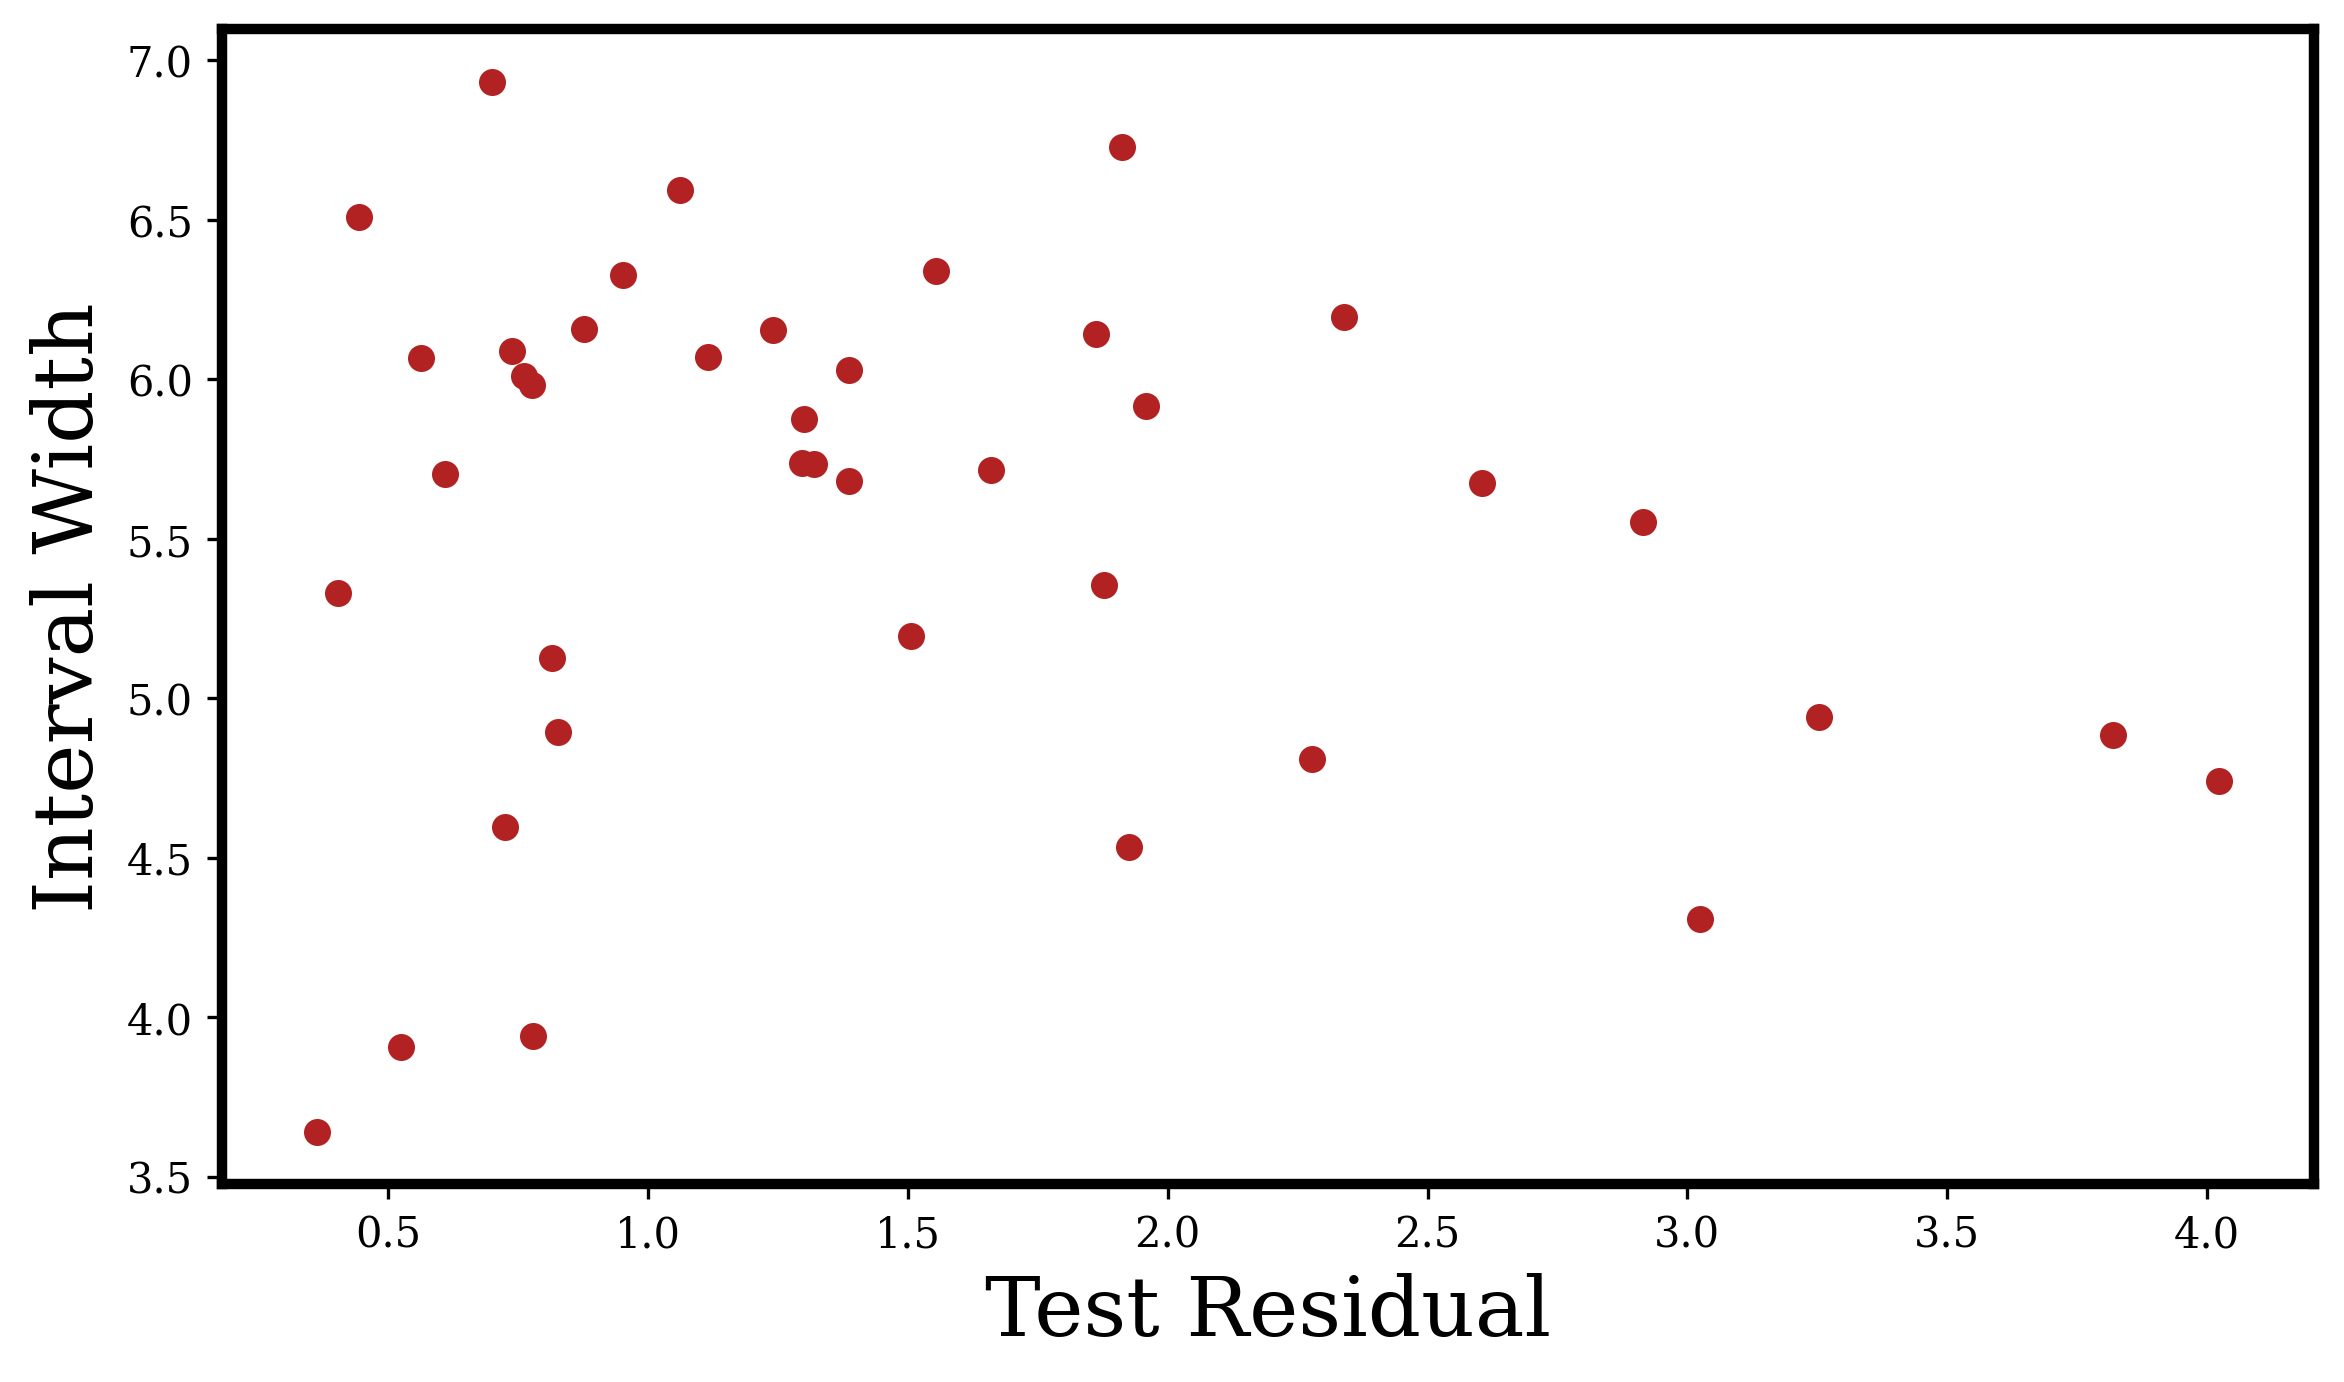

In [120]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(residuals_test, 2 * interval_width, s=30, c='firebrick')
ax.set_xlabel("Test Residual", fontsize=20)
ax.set_ylabel("Interval Width", fontsize=20)
# ax.set_aspect('equal')
for axis in ['bottom','left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2.5)
    
fig.savefig('./interval_widths.png', dpi=200, transparent=True)

In [83]:
sd_2161[orig_sd_test_idx]

array([ 35,  43,  66,  68,  81,  96,  99, 106, 108, 114, 119, 122, 124,
       133, 158, 174, 181, 186, 188, 194, 200, 208, 212, 237, 244, 248,
       256, 257, 258, 266, 267, 268, 277, 279, 287, 292, 302, 306, 311,
       323])

In [322]:
# Loop for saving KLE Images
# sim_ids_all_test = np.array([i for i in range(len(orig_sd_test_idx))])
    
# for i, sim_id in enumerate(sim_ids_all_test):

# #     y0t_data, tt_data, ytt_data = get_data_for_sim(orig_sd_test_idx[sim_id], device=device)

# #     pred_y_test = torch.squeeze(odeint(model,
# #                                         ytt_data[[0], :],
# #                                     y0t_data,
# #                                     tt_data)).cpu()[:, :input_dim] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

opinf_preds = np.load("opinf_siam_predictions.npz")

yMinT = opinf_preds["yMinsAll"][0]
yMaxT = opinf_preds["yMaxsAll"][0]


sim_id = 9
pred_y_test = opinf_preds["pred1"].T * (yMaxT - yMinT) + yMinT

print(sim_id)

tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])

r_true = opinf_preds["truth1"].T * (yMaxT - yMinT) + yMinT
# r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

edut.plotTrainPredData1Model(r_true,
                             pred_y_test,
                             ed_2161,
                             sd_2161,
                             theta=np.linspace(-31, 82, 160),
                             simIdx=orig_sd_test_idx[sim_id],
                             savefig=True,
                             savedir="./opinf_siam2")

9
Saved image for Sim 114


In [97]:
yMaxTrainAll

22.359171674874087